# Pre-Truncate variables: 

In [2]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as kbstats
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [28]:
import importlib
importlib.reload(limkb)
importlib.reload(kbstats)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [7]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Truncate single run: 

In [29]:
# number of EOFs to retain for the LIM state vector
# ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
# nmodes = 50 # number of coupled EOFs for LIM state space (truncated-state space)
#ntrunc_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]
ntrunc_list = [50]
#nmodes = 25
# nmodes_sic = 50
#nmodes_sic_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]
nmodes_sic_list = [50]
#modes_sic = 10

mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

#lat_cutoff = 0.1
lat_cutoff = 40

ntrain = 624

tscut = False     # time start cut 
# tscut_list = 300 
# tecut = tscut+ntrain
#tecut = 16       # time end cut 
#tecut = 10
#tecut = 655       # 500 training years LME
#tecut = 355       # 800 training years LME
tecut = None
#tecut = 1001      # 154 training years LME

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','rlut','zg']
#limvars = ['tas','tos','psl','sit','sic']
#limvars = ['sic']
#limvars = ['tas','tos','psl','zg']
#limvars = ['tas','tos','psl','zg','sit','sic']
limvars = ['sit','sic']

limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'ccsm4_hist_kb'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'cmip6_cesm2_ssp585'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'cesm_lme_regrid_mpilm'
#train_dsource = 'cesm_lme_Amon'
train_dsource = 'multimod_CESM2_MPI_GFDL_HadGEM3_CanESM_hist'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'mpi_lm_kb'
#train_dsource = 'era5'
#train_dsource = 'era5'
valid_dsource = 'cmip6_cesm2_hist'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False
dt=True
wt=True

In [30]:
tecut

In [31]:
if 'hist_ssp585' in train_dsource: 
    folder_add = 'hist_ssp585_concatenated/'
elif 'hist' in train_dsource: 
    folder_add = 'historical/'
elif 'lm' in train_dsource: 
    folder_add = 'last_millennium/'
elif 'satellite' in train_dsource: 
    folder_add = 'satellite/'
elif 'era5' in train_dsource: 
    folder_add = 'reanalysis/'
elif 'lme' in train_dsource: 
    folder_add = 'last_millennium/'

In [32]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names(train_dsource)
areawt_name
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, lat_cutoff=lat_cutoff,remove_climo=False, 
                                                      detrend=False, verbose=False )

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [33]:
# areawt_name['sit'] = 'areacella'
# areawt_name['sic'] = 'areacella'
# areawt_name['tos'] = 'areacella'
areawt_name

{'tas': 'areacella',
 'psl': 'areacella',
 'sic': 'areacello',
 'sit': 'areacello',
 'tos': 'areacello',
 'zg': 'areacella'}

In [34]:
today_date = '20211014'
var_dict = {}

In [35]:
# # ntrunc_list = [50] # EOF truncation for individual fields (reduced-state space)
# ntrunc_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]
# # nmodes_list = [50] # number of coupled EOFs for LIM state space (truncated-state space)
# #nmodes = 25
# nmodes_sic_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]

# ntrain_list = [200]
# tscut_list = [200,400,600]

In [36]:
acell

array([5.02152677e+13, 5.02194234e+13, 5.02268384e+13, ...,
       7.42759165e+12, 7.43072723e+12, 7.43222977e+12])

In [37]:
# for i,tscut in enumerate(tscut_list):
#     ntrain = 200
# #    tecut = 1155-(tscut+ntrain)
#     tecut = tscut+ntrain
# #    tecut = 455
#     print('tscut = '+str(tscut))
#     print('tecut = '+str(tecut))

    
for k, var in enumerate(limvars): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=False, 
                                      detrend=dt, verbose=True, cmip6=False, 
                                      tscut=tscut, tecut=tecut, lat_cutoff=lat_cutoff)

    if mo is 'all':
        print('Using month: '+str(mo))
        X_var_in = X_var
    else: 
        print('Using month: '+str(mo))
        tsamp = X_var.shape[1]
        x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
        X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var_in = X_var_in/100

    acell = areacell[areawt_name[var]]
    if (acell is 'None') and (len(var_dict[var]['lat'].shape) ==1): 
        acell_hold = np.ones((var_dict[var]['lat'].shape[0],var_dict[var]['lon'].shape[0]))
        acell_2d = np.cos(np.deg2rad(var_dict[var]['lat']))[:,np.newaxis]*acell_hold
        acell_1d = np.reshape(acell_2d,(X_var.shape[0]))
        skip_units=True
    elif len(acell.shape)>1:
        acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
        skip_units=False
    else: 
        acell_1d = acell
        skip_units=False

    if skip_units is False: 
        if 'km' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']:
            acell_1d = acell_1d
        elif 'centi' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']: 
            print('changing cellarea units from '+
                  str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
            acell_1d = acell_1d/(100000*100000)    
        else: 
            print('changing cellarea units from '+
                  str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
            acell_1d = acell_1d/(1000*1000)

    for n,ntrunc in enumerate(ntrunc_list):
        nmodes = ntrunc
        nmodes_sic = nmodes_sic_list[n]    

        [Ptrunc, E3, tot_var,
         tot_var_eig, W_all, 
         standard_factor,
         var_expl_by_retained] = limkb.step1_compress_individual_var_sqrt(X_var_in, var, ntrunc, nmodes_sic, 
                                                                         var_dict, areawt=acell_1d,
                                                                         wt=wt, sic_separate=True)

        mod_data_trunc = {}
        mod_data_trunc['var_dict'] = var_dict
        mod_data_trunc['Ptrunc'] = Ptrunc
        mod_data_trunc['E3'] = E3
        mod_data_trunc['standard_factor'] = standard_factor
        mod_data_trunc['W_all'] = W_all

        if 'datetime64' in str(type(var_dict[var]['time'][0])):
            start_yr = str(var_dict[var]['time'][0].astype('M8[Y]'))
            end_yr = str(var_dict[var]['time'][-1].astype('M8[Y]'))
        else: 
            start_yr = str(var_dict[var]['time'][0].year)
            end_yr = str(var_dict[var]['time'][-1].year)

    #        mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'
        mod_folder = ('/home/disk/kalman2/mkb22/SI_LIMs/truncated_data/'+folder_add)

        if var is 'sic':
            nmod = nmodes_sic
        else: 
            nmod = nmodes

        mod_filename = (var+'_ntrunc'+str(nmod)+'_month'+str(mo)+'_'+str(train_dsource)+'_latcutoff_'+
                        str(lat_cutoff)+'_wt'+str(wt)+'_dt'+str(dt)+'_ntrain_'+start_yr+'_'+end_yr+
                        '_'+today_date+'_sqrtWt.pkl')

        print('saving in: '+mod_folder+mod_filename)
        pickle.dump(mod_data_trunc, open(mod_folder+mod_filename, "wb" ) )

Loading from sit
Loading from ach_historical_detrended_latcut40_regridlme_185001-262912.nc
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month

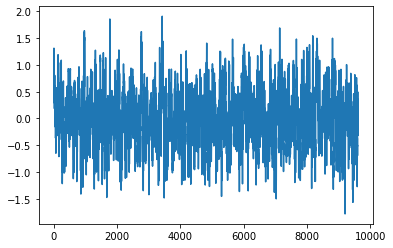

In [57]:
plt.plot(mod_data_trunc['Ptrunc'][0,:])

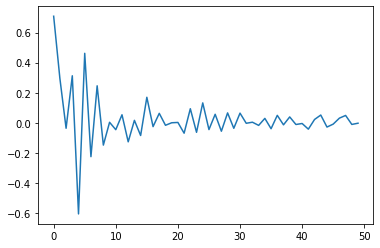

In [53]:
plt.plot(mod_data_trunc['Ptrunc'][:,0])

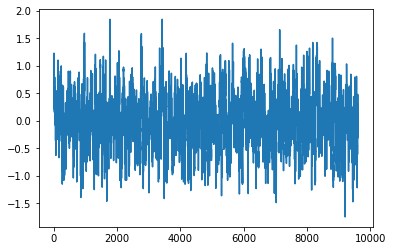

In [54]:
plt.plot(mod_data_trunc['Ptrunc'][0,:])

In [35]:
np.sum(np.var(mod_data_trunc['Ptrunc'],axis=1))

0.9999999999999998

### Multimodel Truncation: No detrend/latcutoff

In [24]:
# number of EOFs to retain for the LIM state vector
# ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
# nmodes = 50 # number of coupled EOFs for LIM state space (truncated-state space)
#ntrunc_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]
ntrunc_list = [50]
#nmodes = 25
# nmodes_sic = 50
#nmodes_sic_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]
nmodes_sic_list = [50]
#modes_sic = 10

mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

#lat_cutoff = 0.1
lat_cutoff = 40

ntrain = 624

tscut = False     # time start cut 
# tscut_list = 300 
# tecut = tscut+ntrain
#tecut = 16       # time end cut 
#tecut = 10
#tecut = 655       # 500 training years LME
#tecut = 355       # 800 training years LME
tecut = None
#tecut = 1001      # 154 training years LME

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','rlut','zg']
#limvars = ['tas','tos','psl','sit','sic']
#limvars = ['sic']
#limvars = ['tas','tos','psl','zg']
#limvars = ['tas','tos','psl','zg','sit','sic']
limvars = ['sit','sic','tos']

limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'ccsm4_hist_kb'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'cmip6_cesm2_ssp585'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'cesm_lme_regrid_mpilm'
#train_dsource = 'cesm_lme_Amon'
train_dsource = 'multimod_MPI_GFDL_HadGEM3_CanESM_hist_latcut40'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'mpi_lm_kb'
#train_dsource = 'era5'
#train_dsource = 'era5'
valid_dsource = 'cmip6_cesm2_hist'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False
dt=True
wt=True

In [25]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names(train_dsource)
areawt_name
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, lat_cutoff=lat_cutoff,remove_climo=False, 
                                                      detrend=False, verbose=False )

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [40]:
np.allclose(X_var1,X_var)

ValueError: operands could not be broadcast together with shapes (7488,96,320) (30720,7488) 

In [31]:
# for i,tscut in enumerate(tscut_list):
#     ntrain = 200
# #    tecut = 1155-(tscut+ntrain)
#     tecut = tscut+ntrain
# #    tecut = 455
#     print('tscut = '+str(tscut))
#     print('tecut = '+str(tecut))

    
for k, var in enumerate(limvars): 
    X_var1, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=False, 
                                      detrend=False, verbose=True, cmip6=False, 
                                      tscut=tscut, tecut=tecut, lat_cutoff=False)

    if mo is 'all':
        print('Using month: '+str(mo))
        X_var_in = X_var
    else: 
        print('Using month: '+str(mo))
        tsamp = X_var.shape[1]
        x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
        X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var_in = X_var_in/100

    acell = areacell[areawt_name[var]]
    if (acell is 'None') and (len(var_dict[var]['lat'].shape) ==1): 
        acell_hold = np.ones((var_dict[var]['lat'].shape[0],var_dict[var]['lon'].shape[0]))
        acell_2d = np.cos(np.deg2rad(var_dict[var]['lat']))[:,np.newaxis]*acell_hold
        acell_1d = np.reshape(acell_2d,(X_var.shape[0]))
        skip_units=True
    elif len(acell.shape)>1:
        acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
        skip_units=False
    else: 
        acell_1d = acell
        skip_units=False

    if skip_units is False: 
        if 'km' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']:
            acell_1d = acell_1d
        elif 'centi' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']: 
            print('changing cellarea units from '+
                  str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
            acell_1d = acell_1d/(100000*100000)    
        else: 
            print('changing cellarea units from '+
                  str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
            acell_1d = acell_1d/(1000*1000)

    for n,ntrunc in enumerate(ntrunc_list):
        nmodes = ntrunc
        nmodes_sic = nmodes_sic_list[n]    

        [Ptrunc, E3, tot_var,
         tot_var_eig, W_all, 
         standard_factor,
         var_expl_by_retained] = limkb.step1_compress_individual_var_sqrt(X_var_in, var, ntrunc, nmodes_sic, 
                                                                         var_dict, areawt=acell_1d,
                                                                         wt=wt, sic_separate=True)

        mod_data_trunc = {}
        mod_data_trunc['var_dict'] = var_dict
        mod_data_trunc['Ptrunc'] = Ptrunc
        mod_data_trunc['E3'] = E3
        mod_data_trunc['standard_factor'] = standard_factor
        mod_data_trunc['W_all'] = W_all

        if 'datetime64' in str(type(var_dict[var]['time'][0])):
            start_yr = str(var_dict[var]['time'][0].astype('M8[Y]'))
            end_yr = str(var_dict[var]['time'][-1].astype('M8[Y]'))
        else: 
            start_yr = str(var_dict[var]['time'][0].year)
            end_yr = str(var_dict[var]['time'][-1].year)

    #        mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'
        mod_folder = ('/home/disk/kalman2/mkb22/SI_LIMs/truncated_data/'+folder_add)

        if var is 'sic':
            nmod = nmodes_sic
        else: 
            nmod = nmodes

        mod_filename = (var+'_ntrunc'+str(nmod)+'_002_month'+str(mo)+'_'+str(train_dsource)+'_latcutoff_'+
                        str(lat_cutoff)+'_wt'+str(wt)+'_dt'+str(dt)+'_ntrain_'+start_yr+'_'+end_yr+
                        '_'+today_date+'_sqrtWt.pkl')

        print('saving in: '+mod_folder+mod_filename)
        pickle.dump(mod_data_trunc, open(mod_folder+mod_filename, "wb" ) )

Loading from sit
Loading from ach_historical_detrended_latcut40_regridlme_185001-247312.nc
No latitude cutoff detected.
-----------------------------------------------------
completed in 0.26991748809814453 seconds
-----------------------------------------------------
Using month: all
changing cellarea units from centimeter^2 to km^2
truncating to 50


ValueError: operands could not be broadcast together with shapes (30720,1) (7488,96,320) 

In [28]:
X_var_in.shape

(7488, 96, 320)

In [29]:
var_dict['sit']

{'sit': {'lat': array([[33.952892, 33.954075, 33.956444, ..., 33.956444, 33.954075,
          33.952892],
         [34.39293 , 34.39415 , 34.39659 , ..., 34.39659 , 34.39415 ,
          34.39293 ],
         [34.831497, 34.832756, 34.83527 , ..., 34.83527 , 34.832756,
          34.831497],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]], dtype=float32),
  'lon': array([[320.5556 , 321.66675, 322.7779 , ..., 317.2221 , 318.33328,
          319.44443],
         [320.55524, 321.6657 , 322.77615, ..., 317.22385, 318.33432,
          319.4448 ],
         [320.55487, 321.6646 , 322.77435, ..., 317.22568, 318.33542,
          319.44516],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [    

## Multimodel ensemble truncation: 

In [65]:
# number of EOFs to retain for the LIM state vector
# ntrunc = 50 # EOF truncation for individual fields (reduced-state space)
# nmodes = 50 # number of coupled EOFs for LIM state space (truncated-state space)
ntrunc = 50
#nmodes = 25
# nmodes_sic = 50
nmodes_sic = 50
#nmodes_sic_list = [5,10,15,20,30,40,50,60,70,80,90,100,150,200]
#modes_sic = 10
nmodes = ntrunc  

mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

lat_cutoff = 40

ntrain = 200

tscut = False     # time start cut 
# tscut_list = 300 
# tecut = tscut+ntrain
#tecut = 16       # time end cut 
#tecut = 10
#tecut = 655       # 500 training years LME
tecut = None       # 800 training years LME
#tecut = 1001      # 154 training years LME

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','rlut','zg']
#limvars = ['tas','tos','psl','sit','sic']
#limvars = ['sic']
limvars = ['tos','sit','sic']
# limvars = ['tas']

limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'ccsm4_hist_kb'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'cmip6_cesm2_ssp585'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'cesm_lme_regrid_mpilm'
train_dsource_list = ['cmip6_cesm2_hist_regridlme','cmip6_mpi_hist_regridlme',
                      'cmip6_gfdl_hist_regridlme','cmip6_HadGEM3_hist_regridlme']
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'mpi_lm_kb'
#train_dsource = 'era5'
#train_dsource = 'era5'
valid_dsource = 'cmip6_cesm2_hist'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False
dt=True
wt=True

In [66]:
today_date = '20211014'
var_dict_all = {}

In [67]:
for k, var in enumerate(limvars): 
    for i,train_dsource in enumerate(train_dsource_list):
        print('WORKING ON: '+train_dsource)
        var_dict = {}
        
        fdic_train = limkb.build_training_dic(train_dsource)
        fdic_valid = limkb.build_training_dic(valid_dsource)

        full_names, areawt_name, month_names = limbuild.load_full_names()
        areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, lat_cutoff=lat_cutoff,
                                                              remove_climo=False, 
                                                              detrend=False, verbose=False )

        X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
                                          detrend=dt, verbose=True, cmip6=False, 
                                          tscut=tscut, tecut=tecut, lat_cutoff=lat_cutoff)

        if mo is 'all':
            print('Using month: '+str(mo))
            X_var_in = X_var
        else: 
            print('Using month: '+str(mo))
            tsamp = X_var.shape[1]
            x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
            X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))

        if var is 'sic':
            if np.nanmax(X_var)>1:
                print('Changing units of sic be a between 0 to 1')
                X_var_in = X_var_in/100

        acell = areacell[areawt_name[var]]
        if (acell is 'None') and (len(var_dict[var]['lat'].shape) ==1): 
            acell_hold = np.ones((var_dict[var]['lat'].shape[0],var_dict[var]['lon'].shape[0]))
            acell_2d = np.cos(np.deg2rad(var_dict[var]['lat']))[:,np.newaxis]*acell_hold
            acell_1d = np.reshape(acell_2d,(X_var.shape[0]))
            skip_units=True
        elif len(acell.shape)>1:
            acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
            skip_units=False
        else: 
            acell_1d = acell
            skip_units=False

        if skip_units is False: 
            if 'km' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']:
                acell_1d = acell_1d
            elif 'centi' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']: 
                print('changing cellarea units from '+
                      str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
                acell_1d = acell_1d/(100000*100000)    
            else: 
                print('changing cellarea units from '+
                      str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
                acell_1d = acell_1d/(1000*1000)
                
        if i == 0: 
            X_var_in_all = X_var_in
            acell_1d_all = acell_1d
            print('X_var_in.shape = '+str(X_var_in.shape))
            print('X_var_in_all.shape = '+str(X_var_in_all.shape))
        else: 
            X_var_in_all = np.concatenate((X_var_in_all,X_var_in),axis=1)
            acell_1d_all = np.concatenate((acell_1d_all,acell_1d),axis=0)
            print('X_var_in.shape = '+str(X_var_in.shape))
            print('X_var_in_all.shape = '+str(X_var_in_all.shape))
            
        var_dict_all[train_dsource] = var_dict

 

    [Ptrunc, E3, tot_var,
     tot_var_eig, W_all, 
     standard_factor,
     var_expl_by_retained] = limkb.step1_compress_individual_var(X_var_in_all, var, ntrunc, nmodes_sic, 
                                                                 var_dict, areawt=acell_1d,
                                                                 wt=wt, sic_separate=True)

    mod_data_trunc = {}
    mod_data_trunc['var_dict_all'] = var_dict_all
    mod_data_trunc['Ptrunc'] = Ptrunc
    mod_data_trunc['E3'] = E3
    mod_data_trunc['standard_factor'] = standard_factor
    mod_data_trunc['W_all'] = W_all

    if 'datetime64' in str(type(var_dict[var]['time'][0])):
        start_yr = str(var_dict[var]['time'][0].astype('M8[Y]'))
        end_yr = str(var_dict[var]['time'][-1].astype('M8[Y]'))
    else: 
        start_yr = str(var_dict[var]['time'][0].year)
        end_yr = str(var_dict[var]['time'][-1].year)

#        mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'
    mod_folder = ('/home/disk/kalman2/mkb22/SI_LIMs/truncated_data/historical/')

    if var is 'sic':
        nmod = nmodes_sic
    else: 
        nmod = nmodes

    mod_filename = (var+'_ntrunc_multimod_CESM2_MPI_GFDL_HadGEM3_month'+str(mo)+
                    '_'+str(train_dsource)+'_latcutoff_'+str(lat_cutoff)+'_wt'+
                    str(wt)+'_dt'+str(dt)+'_ntrain_'+start_yr+'_'+end_yr+
                    '_'+today_date+'.pkl')

    print('saving in: '+mod_folder+mod_filename)
    pickle.dump(mod_data_trunc, open(mod_folder+mod_filename, "wb" ) )

WORKING ON: cmip6_cesm2_hist_regridlme
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from m2-historical/areacello_Ofx_CESM2_historical_r11i1p1f1_gn.nc
latitude cutoff detected: 40
Loading from tas
Loading from as_Amon_CESM2_historical_r1i1p1f1_regridLME_185001-201412.nc
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 2.639407157897949 seconds
-----------------------------------------------------
Using month: all
changing cellarea units from m^2 to km^2
X_var_in.shape = (3888, 1980)
X_var_in_all.shape = (3888, 1980)
WORKING ON: cmip6_mpi_hist_regridlme
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_g

Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed in 32.15140390396118 seconds
-----------------------------------------------------
Using month: all
changing cellarea units from centimeter^2 to km^2
X_var_in.shape = (30720, 1980)
X_var_in_all.shape = (30720, 5940)
WORKING ON: cmip6_HadGEM3_hist_regridlme
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from tos
Loading from dGEM3-GC31-LL_hi

latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 3.8881380558013916 seconds
-----------------------------------------------------
Using month: all
changing cellarea units from m^2 to km^2
X_var_in.shape = (3888, 1980)
X_var_in_all.shape = (3888, 5940)
WORKING ON: cmip6_HadGEM3_hist_regridlme
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from zg
Loading from dGEM3-GC31-LL_historical_r1i1p1f3_regridlme_185001-201412.nc
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on 

X_var_in.shape = (30720, 1980)
X_var_in_all.shape = (30720, 7920)
truncating to 50
fraction in first 50 sit EOFs = 78.8844627618761
saving in: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/historical/sit_ntrunc_multimod_CESM2_MPI_GFDL_HadGEM3_monthall_cmip6_HadGEM3_hist_regridlme_latcutoff_40_wtTrue_dtTrue_ntrain_1850_2014_20211014.pkl
WORKING ON: cmip6_cesm2_hist_regridlme
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from m2-historical/areacello_Ofx_CESM2_historical_r11i1p1f1_gn.nc
latitude cutoff detected: 40
Loading from sic
Loading from ical/sic_SImon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found

In [71]:
Ptrunc.shape[1]/12

660.0

### Check by decompressing data: 

In [ ]:
x_forecast_dcomp = limkb.decompress_eof_separate_sic(Ptrunc, nmodes,50,LIMd['E3_all'],
                                                      LIMd['E_sic'],exp_setup['limvars'],LIMd['var_dict'],
                                                      LIMd['W_all'],Weights=exp_setup['Weight'],
                                                      sic_separate=exp_setup['sic_separate'])

In [59]:
x_decomp = np.matmul(E3,Ptrunc)
x_dcomp = x_decomp/W_all[:,np.newaxis]

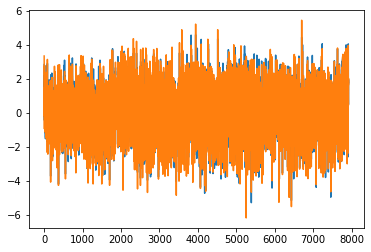

In [61]:
plt.plot(x_dcomp[0,:])
plt.plot(X_var_in_all[0,:])

In [50]:
X_var_in_all

array([[3.32756144, 1.41930714, 0.88403584, ..., 1.99266791, 2.01185775,
        1.65200961],
       [2.40114779, 0.99947287, 0.66962459, ..., 2.05294323, 1.73798883,
        1.45493472],
       [2.00805079, 0.79980817, 0.59154175, ..., 2.3158865 , 1.53120172,
        1.58748043],
       ...,
       [3.92268031, 2.8742202 , 0.7881273 , ..., 1.52109635, 0.2844418 ,
        4.95173359],
       [3.92268031, 2.8742202 , 0.7881273 , ..., 1.52109635, 0.2844418 ,
        4.95173359],
       [3.92268031, 2.8742202 , 0.7881273 , ..., 1.52109635, 0.2844418 ,
        4.95173359]])

In [48]:
np.allclose(X_var_in_all,x_dcomp)

False

In [9]:
%run ../sensitivity_testing/run_forecast_LME_multimod_train_crossmodel_validation_011422.py

Loading truncated tas from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/historical/tas_ntrunc_multimod_CESM2_MPI_GFDL_HadGEM3_monthall_latcutoff_40_wtTrue_dtTrue_ntrain_1850_2014_20211014.pkl
Month is all
Loading truncated psl from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/historical/psl_ntrunc_multimod_CESM2_MPI_GFDL_HadGEM3_monthall_latcutoff_40_wtTrue_dtTrue_ntrain_1850_2014_20211014.pkl
Month is all
Loading truncated tos from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/historical/tos_ntrunc_multimod_CESM2_MPI_GFDL_HadGEM3_monthall_latcutoff_40_wtTrue_dtTrue_ntrain_1850_2014_20211014.pkl
Month is all
Loading truncated sic from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/historical/sic_ntrunc_multimod_CESM2_MPI_GFDL_HadGEM3_monthall_latcutoff_40_wtTrue_dtTrue_ntrain_1850_2014_20211014.pkl
Month is all
nyears_train = 7920
working on tas
working on psl
working on tos
working on sic
Multiple variables detected...
0, tas
1, psl
2, tos
Training LIM with tau = 1
Number

KeyboardInterrupt: 

In [2]:
%run ../sensitivity_testing/run_forecast_LME_nvalid_sensitivity_120221.py

Loading truncated tas from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tas_ntrunc50_002_monthall_cesm_lme_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated psl from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/psl_ntrunc50_002_monthall_cesm_lme_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated zg from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/zg_ntrunc50_002_monthall_cesm_lme_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated tos from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tos_ntrunc50_002_monthall_cesm_lme_latcutoff_0.1_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated sit from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/sit_ntrunc50_002_monthall_cesm_lme_latcutoff_40_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated 

lag= 4
lag= 5
lag= 6
lag= 7
lag= 8
LIM_fcast: (9, 300, 2400)
Decompressing forecasted fields out of eof space.
Working on...
Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6
Lag 7
Lag 8
------------------------------------------------
------------------------------------------------
STARTING validate_forecast_monthly()
------------------------------------------------
------------------------------------------------
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 0.1
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_0

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
tecut = 1001, tscut = 801.0
Loading from tos
Loading from a/LME/LIMs/tos_sfc_Omon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 1651 - 1850
latitude cutoff detected: 0.1
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satel

Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed in 24.766630172729492 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (30720, 199)
Forecast_anom shape: (30720, 199)
changing cellarea units from centimeter^2 to km^2
Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (30720, 200)
Forecast_anom shape: (30720, 200)
changing cellarea units from centimeter^2 to km^2
Month 3
Trained using month 

Lag 4
Trained using all months...
Truth_anom shape: (6912, 2396)
Forecast_anom shape: (6912, 2396)
changing cellarea units from m^2 to km^2
Lag 5
Trained using all months...
Truth_anom shape: (6912, 2395)
Forecast_anom shape: (6912, 2395)
changing cellarea units from m^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (6912, 2394)
Forecast_anom shape: (6912, 2394)
changing cellarea units from m^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (6912, 2393)
Forecast_anom shape: (6912, 2393)
changing cellarea units from m^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (6912, 2392)
Forecast_anom shape: (6912, 2392)
changing cellarea units from m^2 to km^2
tecut = 1001, tscut = 801.0
Loading from tos
Loading from a/LME/LIMs/tos_sfc_Omon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 1651 - 1850
latitude cutoff detected: 0.1
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Fou

Lag 5
Trained using all months...
Truth_anom shape: (30720, 2395)
Forecast_anom shape: (30720, 2395)
changing cellarea units from centimeter^2 to km^2
Lag 6
Trained using all months...
Truth_anom shape: (30720, 2394)
Forecast_anom shape: (30720, 2394)
changing cellarea units from centimeter^2 to km^2
Lag 7
Trained using all months...
Truth_anom shape: (30720, 2393)
Forecast_anom shape: (30720, 2393)
changing cellarea units from centimeter^2 to km^2
Lag 8
Trained using all months...
Truth_anom shape: (30720, 2392)
Forecast_anom shape: (30720, 2392)
changing cellarea units from centimeter^2 to km^2
------------------------------------------------
------------------------------------------------
STARTING ar1_forecast_valid_by_month()
------------------------------------------------
------------------------------------------------
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_L

Trained using month 7...
Validating against month 7
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
Month 11
Trained using month 11...
Validating against month 11
Truth_anom shape: (6912, 200)
Forecast_anom shape: (6912, 200)
changing cellarea units from m^2 to km^2
tecut = 1001, tscut = 801.0
Loading from tos
Loading from a/LME/LIMs/tos_sfc_Omon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 1651 - 1850
latitude cutoff detected: 0.1
detre

Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in satellite), going to fill with zeros...
Working on month...11
Found with nans (not in satellite), going to fill with zeros...
-----------------------------------------------------
completed in 25.079983472824097 seconds
-----------------------------------------------------
Changing units of sic be a between 0 to 1
Month 0
Trained using month 0...
Validating

MemoryError: Unable to allocate 23.4 GiB for an array with shape (9, 145216, 2400) and data type float64

In [75]:
mod_folder = '/home/disk/kalman2/mkb22/SI_LIMs/truncated_data/historical/'
mod_data = pickle.load(open(mod_folder+'sic_ntrunc_multimod_CESM2_MPI_GFDL_HadGEM3_monthall_latcutoff_40_wtTrue_dtTrue_ntrain_1850_2014_20211014.pkl', "rb" ) )

In [80]:
mod_data['var_dict_all'].keys()

dict_keys(['cmip6_cesm2_hist_regridlme', 'cmip6_mpi_hist_regridlme', 'cmip6_gfdl_hist_regridlme', 'cmip6_HadGEM3_hist_regridlme'])

In [ ]:
plt.pcolormesh(np.reshape(areacell[areawt_name[var]]*mask)
plt.colorbar()

In [ ]:
plt.pcolormesh(np.where(var_dict['tos']['lat']>=30,var_dict['tos']['lat'],0))
plt.colorbar()

In [ ]:
areacell[areawt_name[var]]

In [ ]:
data_in = xr.open_dataset(fdic_train[var])

In [ ]:
fdic_train[var]

In [ ]:
if 'LME' in fdic_train[var]:
    print('LME detected')
    data_in = data_in.sel(member=1)
    if 'tos' in var: 
        data_in = data_in.isel(time=slice(12,13872))
    elif 'sic' in var: 
        print('sic_detected.')
        data_in = data_in.isel(time=slice(11,11999))

In [ ]:
data_in.time

In [ ]:
var

In [ ]:
limvars = ['tas','sic']

for k, var in enumerate(limvars): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
                                      detrend=dt, verbose=True, cmip6=False, 
                                      tscut=tscut, tecut=tecut, lat_cutoff=lat_cutoff)

In [ ]:
var_dict['tas']['time'][0]

In [ ]:
var_dict['sic']['time'][0]

### Plot truncated vs truth (global metrics): 

In [ ]:
#var = 'sic'
#--------------------------------------------------------  
# Calc total gobal quantity for truth: 
#--------------------------------------------------------  
units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
if 'km' in units:
        acell = areacell[areawt_name[var]]
else: 
    print('changing cellarea units from '+
          str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[areawt_name[var]]/(1000*1000)
    units = 'km^2'

if var == 'sic':
    tot_truth = kbstats.calc_tot_si_checks(X_var,acell,units,var_dict[var]['lat'],
                                          var_dict[var]['lon'].shape[1],lat_cutoff=0.0)
else: 
    tot_truth = kbstats.global_mean(X_var,acell)

#--------------------------------------------------------    
# Calc total gobal quantity for truncated variable: 
#--------------------------------------------------------  
print('Working on decompressing variable...')
w_all = {}
w_all[var] = mod_data_trunc['W_all']

decomp_test = limkb.decompress_eof_separate_sic(mod_data_trunc['Ptrunc'],nmodes,nmodes_sic,
                                                mod_data_trunc['E3'],mod_data_trunc['E3'],
                                                limvars,var_dict,
                                                w_all,Weights=wt,
                                                sic_separate=sic_separate)

units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
if 'km' in units:
        acell = areacell[areawt_name[var]]
else: 
    print('changing cellarea units from '+
          str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[areawt_name[var]]/(1000*1000)
    units = 'km^2'

if var == 'sic':
    tot_decomp_test = kbstats.calc_tot_si_checks(decomp_test,acell,units,var_dict[var]['lat'],
                                                 var_dict[var]['lon'].shape[1],lat_cutoff=0.0)
else: 
    tot_decomp_test = kbstats.global_mean(decomp_test,acell)
    
    
plt.plot(tot_truth, label='truth')
plt.plot(tot_decomp_test, label='truncated')
plt.title('Global metric: '+var+' , '+train_dsource)
plt.legend()
#plt.xlim(0,50)

In [ ]:
mod_data_trunc = {}

mod_data_trunc['var_dict'] = var_dict
mod_data_trunc['Ptrunc'] = Ptrunc
mod_data_trunc['E3'] = E3
mod_data_trunc['standard_factor'] = standard_factor
mod_data_trunc['W_all'] = W_all

In [ ]:
if 'datetime64' in str(type(var_dict[var]['time'][0])):
    start_yr = str(var_dict[var]['time'][0].astype('M8[Y]'))
    end_yr = str(var_dict[var]['time'][-1].astype('M8[Y]'))
else: 
    start_yr = str(var_dict[var]['time'][0].year)
    end_yr = str(var_dict[var]['time'][-1].year)

mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'

if var is 'sic':
    nmod = nmodes_sic
else: 
    nmod = nmodes
    
mod_filename = (var+'_ntrunc'+str(nmod)+'_month'+str(mo)+'_'+str(train_dsource)+# '_grid05'+
                '_ntrain_'+start_yr+'_'+end_yr+'_'+today_date+'.pkl')

#print('would save in: '+mod_folder+mod_filename)

In [ ]:
print('saving in: '+mod_folder+mod_filename)
pickle.dump(mod_data_trunc, open(mod_folder+mod_filename, "wb" ) )

## Truncate concatenated runs: 

In [ ]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 1
ntraintimes = 1980
# nvalidtimes = 1872
nttrain_valid = 0
tscut1 = False    # time start cut 
tecut1 = 10       # time end cut 

tscut2 = False    # time start cut 
tecut2 = 50       # time end cut 

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
#limvars = ['tas','tos','sic']
#limvars_nosic = ['tas','tos']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'ccsm4_hist_kb'
#train_dsource = 'mpi_hist_kb'
train_dsource1 = 'cmip6_mpi_hist'

train_dsource2 = 'cmip6_mpi_ssp585'


sic_separate = True
Insamp = False

In [ ]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_train1 = limkb.build_training_dic(train_dsource1)
fdic_train2 = limkb.build_training_dic(train_dsource2)
#fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train1, remove_climo=False, 
                                                      detrend=False, verbose=False )

In [ ]:
wt=True
var_dict1 = {}
var_dict2 = {}

for k, var in enumerate(limvars):
    X_var1, var_dict1 = limkb.load_data(var, var_dict1, fdic_train1, remove_climo=True, 
                                      detrend=True, atol=False, verbose=True, cmip6=False, 
                                      tscut=tscut1, tecut=tecut1)
    
    X_var2, var_dict2 = limkb.load_data(var, var_dict2, fdic_train2, remove_climo=True, 
                                        detrend=True, atol=False, verbose=True, cmip6=False, 
                                        tscut=tscut2, tecut=tecut2)
    
    if var is 'sic':
        if np.nanmax(X_var1)>1:
            print('Changing units of ds1 sic be a between 0 to 1')
            X_var1 = X_var1/100
        if np.nanmax(X_var2)>1:
            print('Changing units of ds2 sic be a between 0 to 1')
            X_var2 = X_var2/100
    
    X_var = np.concatenate((X_var1,X_var2),axis=1)

    tsamp = X_var.shape[1]
    
    acell = areacell[areawt_name[var]]
    if len(acell.shape)>1:
        acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
    else: 
        acell_1d = acell
        
    if 'km' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']:
        acell_1d = acell_1d
    else: 
        print('changing cellarea units from '+
              str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
        acell_1d = acell_1d/(1000*1000)
     
    [Ptrunc, E3, tot_var,
     tot_var_eig, W_all, 
     standard_factor,
     var_expl_by_retained] = limkb.step1_compress_individual_var(X_var, var, ntrunc, nmodes_sic, 
                                                                 var_dict1, areawt=acell_1d,
                                                                  wt=wt, sic_separate=True)
    
    v = {}
    var_dict = {}
    v['lat'] = var_dict1[var]['lat']
    v['lon'] = var_dict1[var]['lon']
    v['var_ndof'] = var_dict1[var]['var_ndof']
    v['time'] = np.concatenate((var_dict1[var]['time'], var_dict2[var]['time']))
    v['climo'] = np.concatenate((var_dict1[var]['climo'], var_dict2[var]['climo']))

    var_dict[var] = v

In [ ]:
mod_data_trunc = {}

mod_data_trunc['var_dict1'] = var_dict1
mod_data_trunc['var_dict2'] = var_dict2
mod_data_trunc['var_dict'] = var_dict

mod_data_trunc['Ptrunc'] = Ptrunc
mod_data_trunc['E3'] = E3
mod_data_trunc['standard_factor'] = standard_factor
mod_data_trunc['W_all'] = W_all

In [ ]:
if 'datetime64' in str(type(var_dict[var]['time'][0])):
    start_yr = str(var_dict[var]['time'][0].astype('M8[Y]'))
    end_yr = str(var_dict[var]['time'][-1].astype('M8[Y]'))
else: 
    start_yr = str(var_dict[var]['time'][0].year)
    end_yr = str(var_dict[var]['time'][-1].year)

mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'

if var is 'sic':
    nmod = nmodes_sic
else: 
    nmod = nmodes
    
mod_filename = (var+'_ntrunc'+str(nmod)+'_month'+str(mo)+'_'+str(train_dsource1)+'_'+str(train_dsource2)[-6:]+
                '_ntrain_'+start_yr+'_'+end_yr+'_'+today_date+'.pkl')

print('would save in: '+mod_folder+mod_filename)

In [ ]:
print('saving in: '+mod_folder+mod_filename)
pickle.dump(mod_data_trunc, open(mod_folder+mod_filename, "wb" ) )

In [ ]:
exp_setup = {}
exp_setup['nyearsvalid'] = 16
exp_setup['nyearstot'] = 42
exp_setup['nyears_startvalid'] = 0 # 26*12

In [ ]:
exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))

In [ ]:
exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))

## Look at EOFs: 

In [ ]:
var = 'sic'
neofs = 16
#filename = var+'_ntrunc'+str(neofs)+'_monthall_cmip6_mpi_hist_ssp585_20210910_ntrain_1850_2050_standtest.pkl'
#filename = var+'_ntrunc'+str(neofs)+'_monthall_satellite_ntrain_1979_2016_20210914.pkl'
#filename = var+'_ntrunc'+str(neofs)+'_monthall_satellite_ntrain_1979_2000_20210914.pkl'
#filename = 'hist_ssp585_concatenated/sic_ntrunc50_monthall_cmip6_mpi_hist_ssp585_ntrain_1850_2050_20210910.pkl'
#filename = 'reanalysis/sic_ntrunc50_monthall_era5_grid05_ntrain_1979_2020_20210915.pkl'
#filename = 'sic_ntrunc50_monthall_satellite_latcutoff_50_nowt_ntrain_1979_2004_20210929.pkl'
#filename = 'sic_ntrunc50_monthall_satellite_latcutoff_False_wtTrue_dtTrue_ntrain_1979_2004_20210929.pkl'
#filename = var+'_ntrunc'+str(neofs)+'_monthall_cmip6_mpi_hist_ntrain_1850_2004_20210921.pkl'
#filename = 'sic_ntrunc50_monthall_era5_ntrain_1979_2004_20210916_Wt_False.pkl'
#filename = 'sic_ntrunc50_monthall_cmip6_mpi_hist_ssp585_ntrain_1850_2050_20210916.pkl'
#filename = 'sic_ntrunc50_monthall_cmip6_mpi_hist_latcutoff_50_ntrain_1850_2004_20210923.pkl'
#filename = 'sic_ntrunc50_monthall_era5_latcutoff_50_nowt_ntrain_1979_2010_20210923.pkl'
#filename = 'tas_ntrunc30_monthall_era5_latcutoff_50_nowt_ntrain_1979_2004_20210923.pkl'
#filename = 'sic_ntrunc16_monthall_era5_latcutoff_50_wtTrue_dtTrue_ntrain_1979_2004_20211005.pkl'
filename = 'sic_ntrunc16_monthall_satellite_latcutoff_50_wtFalse_dtTrue_ntrain_1979_2004_20211006.pkl'

In [ ]:
trunc_data = pickle.load(open(filename, "rb" ) )
trunc_data.keys()

In [ ]:
neofs,int(trunc_data['Ptrunc'].shape[1]/12),12, trunc_data['Ptrunc'].shape

In [ ]:
312/12

In [ ]:
Ptrunc_3d = np.reshape(trunc_data['Ptrunc'],(neofs,int(trunc_data['Ptrunc'].shape[1]/12),12))

In [ ]:
time = np.arange(1850,2051,1)
time_cut = np.delete(time,np.where((time>2004)&(time<2015)))

In [ ]:
plt.plot(trunc_data['Ptrunc'][5,:]), trunc_data['Ptrunc'].shape

In [ ]:
time_cut.shape

In [ ]:
plt.plot(Ptrunc_3d[0,:,0])
plt.plot(Ptrunc_3d[0,:,1])
plt.plot(Ptrunc_3d[0,:,2])
#plt.xlim(2000,2025)
# plt.axvline(2004, color='k')
# plt.axvline(2015, color='k')

In [ ]:
trunc_data['E3'].shape, trunc_data['var_dict'][var]['lat'].shape, len(trunc_data['var_dict'][var]['lon'].shape)

In [ ]:
trunc_data['var_dict'][var]['lat'].shape[0], trunc_data['var_dict'][var]['lon'].shape[0]

In [ ]:
if len(trunc_data['var_dict'][var]['lat'].shape)>1:
    nlat = trunc_data['var_dict'][var]['lat'].shape[0]
    nlon = trunc_data['var_dict'][var]['lon'].shape[1]
else: 
    nlat = trunc_data['var_dict'][var]['lat'].shape[0]
    nlon = trunc_data['var_dict'][var]['lon'].shape[0]

eof_3d = np.reshape(trunc_data['E3'],(nlat,nlon,neofs))

# plt.pcolormesh(trunc_data['var_dict']['sic']['lon'],
#                trunc_data['var_dict']['sic']['lat'],eof)

In [ ]:
trunc_data['E3'].shape

In [ ]:
lat_mask = np.where((trunc_data['var_dict']['sic']['lat']<100),1,0)

In [ ]:
plt.pcolormesh(eof_3d[:,:,1],cmap='RdBu', vmax=eof_3d[(trunc_data['var_dict'][var]['lat']>0),0].max(), 
               vmin = -eof_3d[(trunc_data['var_dict'][var]['lat']>0),0].max())
#plt.scatter(75,20, color='r')
plt.colorbar()

In [ ]:
(trunc_data['var_dict'][var]['lat']>0).sum()

In [ ]:
trunc_data['var_dict'][var]['lon'].shape

In [ ]:
import matplotlib.path as mpath
modes = [0,1,2,3]

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title('Mode #'+str(mode), fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(eof_3d[(trunc_data['var_dict'][var]['lat']>0),mode]))
    cf = ax[i].pcolormesh(trunc_data['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          trunc_data['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          eof_3d[:,:,mode],cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle('Satellite SIC EOFs (no area weighting)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
import matplotlib.path as mpath
modes = [0,1,2,3]

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title('Mode #'+str(mode), fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(eof_3d[(trunc_data['var_dict'][var]['lat']>0),mode]))
    cf = ax[i].pcolormesh(trunc_data['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          trunc_data['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          eof_3d[:,:,mode],cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle('Satellite (detrended) EOFs', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
import matplotlib.path as mpath
modes = [0,4,8,12]

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title('Mode #'+str(mode), fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(eof_3d[:,:,mode]))
    cf = ax[i].pcolormesh(trunc_data['var_dict']['sic']['lon'],trunc_data['var_dict']['sic']['lat'],
                          eof_3d[:,:,mode],cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle('MPI historical: Real parts', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## No more sea ice?

In [ ]:
var = 'sic'

X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=False, 
                                      detrend=False, verbose=True, cmip6=False, 
                                      tscut=tscut, tecut=tecut)
X_var_2d = np.reshape(X_var,(X_var.shape[0],X_var.shape[1]*X_var.shape[2])).T

units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']

tot_var = statskb.calc_tot_si(X_var_2d, areacell[areawt_name[var]], 
                              units, var_dict[var]['lat'], lat_cutoff=0.0)

tot_var_mo = np.reshape(tot_var, (int(tot_var.shape[0]/12),12))

In [ ]:
plt.plot(tot_var_mo[:,8])
plt.plot(tot_var_mo[:,7])
plt.plot(tot_var_mo[:,9])
plt.axhline(5e5, color='r')
plt.xlim(30,60)

In [ ]:
# Time August sea ice drops below 0.5 x 10^6 km^2:
noice_yr = np.where(tot_var_mo[:,7]<5e5)[0][0]
var_dict[var]['time'][noice_yr*12]

In [ ]:
plt.plot(tot_var)
plt.axhline(5e5, color='r')
# plt.xlim(400,900)

In [ ]:
2005-850

## Track variance explained per # of eofs retained: 

In [19]:
#limvars = ['psl','tas','tos','sit']
#limvars = ['tos','sit']
limvars = ['sic']

mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

lat_cutoff = 40

tscut = False    # time start cut 
#tecut = 16       # time end cut 
#tecut = 10
tecut = 355

# specify the model source 
#train_dsource = 'ccsm4_hist_kb'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'cmip6_cesm2_ssp585'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'mpi_lm_kb'
#train_dsource = 'satellite'
train_dsource = 'cesm_lme'
#train_dsource = 'era5'
valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False
dt=True
wt=True

In [20]:
pi = np.pi

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, lat_cutoff=lat_cutoff,remove_climo=False, 
                                                      detrend=False, verbose=False )

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [24]:
limvars = ['tas','psl','zg','tos','sit','sic']

In [25]:
neofs = [5,10,15,20,25,30,35,40,45,50,55,60,65,70]
var_explained = {}
var_dict = {}

for k, var in enumerate(limvars): 
    var_expl_by_retained = np.zeros(len(neofs))
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
                                      detrend=dt, verbose=True, cmip6=False, 
                                      tscut=tscut, tecut=tecut, lat_cutoff=lat_cutoff)
    
    if mo is 'all':
        print('Using month: '+str(mo))
        X_var_in = X_var
    else: 
        print('Using month: '+str(mo))
        tsamp = X_var.shape[1]
        x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
        X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))
        
    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var_in = X_var_in/100
    
    acell = areacell[areawt_name[var]]
    
    if (acell is 'None') and (len(var_dict[var]['lat'].shape) ==1): 
        acell_hold = np.ones((var_dict[var]['lat'].shape[0],var_dict[var]['lon'].shape[0]))
        acell_2d = np.cos(np.deg2rad(var_dict[var]['lat']))[:,np.newaxis]*acell_hold
        acell_1d = np.reshape(acell_2d,(X_var.shape[0]))
        skip_units=True
    elif len(acell.shape)>1:
        acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
        skip_units=False
    else: 
        acell_1d = acell
        skip_units=False
    
    if skip_units is False: 
        if 'km' in areacell_dict[areawt_name[var]][areawt_name[var]]['units']:
            acell_1d = acell_1d
        else: 
            print('changing cellarea units from '+
                  str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
            acell_1d = acell_1d/(1000*1000)
    
    for n,nt in enumerate(neofs):
        [_,_,_,_,_,_,
         var_expl_by_retained[n]] = limkb.step1_compress_individual_var(X_var_in, var, nt, nt, 
                                                                          var_dict, areawt=acell_1d,
                                                                          wt=wt, sic_separate=True)
        
    var_explained[var] = var_expl_by_retained

Loading from tas
Loading from a/LME/LIMs/tas_sfc_Amon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 850 - 1650
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
latitude cutoff detected: 40
-----------------------------------------------------
completed in 15.93342399597168 seconds
-----------------------------------------------------
Using month: all
changing cellarea units from m^2 to km^2
truncating to 5
fraction in first 5 tas EOFs = 50.88049956920614
truncating to 10
fraction in first 10 tas EOFs = 67.59600660581535
truncating to 15
fraction in first 15 tas EOFs = 75.6499479566352
truncating to 20
fraction in first 20 tas EOFs = 80.6029486456134
truncating to 25
fraction in first 25 tas EOFs = 84.00972404628874
truncating to 30
fraction in first 30 tas EOFs = 

fraction in first 5 sit EOFs = 52.80465954150029
truncating to 10
fraction in first 10 sit EOFs = 65.79547974487159
truncating to 15
fraction in first 15 sit EOFs = 71.89040425491045
truncating to 20
fraction in first 20 sit EOFs = 75.73399691755559
truncating to 25
fraction in first 25 sit EOFs = 78.58495000845006
truncating to 30
fraction in first 30 sit EOFs = 80.76513577866267
truncating to 35
fraction in first 35 sit EOFs = 82.59368999605718
truncating to 40
fraction in first 40 sit EOFs = 84.14460462618527
truncating to 45
fraction in first 45 sit EOFs = 85.4129409163377
truncating to 50
fraction in first 50 sit EOFs = 86.48393177496885
truncating to 55
fraction in first 55 sit EOFs = 87.3951569539242
truncating to 60
fraction in first 60 sit EOFs = 88.21870176464937
truncating to 65
fraction in first 65 sit EOFs = 88.95269936884705
truncating to 70
fraction in first 70 sit EOFs = 89.59302530396009
Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-2

In [22]:
var_expl_by_retained

array([33.72385089, 48.28120338, 56.64863502, 62.58844441, 67.01753918,
       70.53552805, 73.37247715, 75.72670245, 77.72693156, 79.43513606,
       80.88343658, 82.17064086, 83.3093473 , 84.32498156])

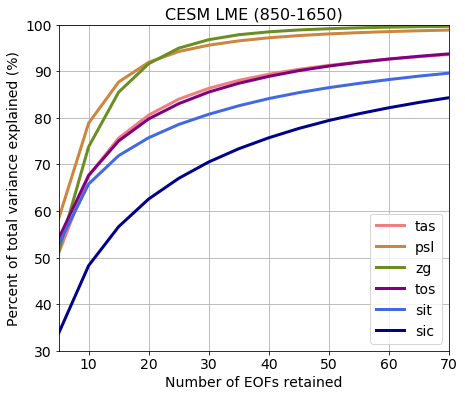

In [41]:
#limvars = ['psl','tas','tos','sit','sic']
# limvars = ['psl','tas','tos','sit','sic']
# colors = ['lightcoral','peru','olivedrab','purple','royalblue','darkblue']
# colors = ['olivedrab','peru','purple','royalblue']

fig = plt.figure(figsize=(7,6))

colors = {'tas':'salmon', 
          'psl':'orange',
          'zg':'firebrick',
          'tos':'royalblue',
          'sit':'deepskyblue',
          'sic':'k'}

labels = {'tas':'TAS','psl':'PSL','zg':'ZG500','tos':'SST',
          'sit':'SIT','sic':'SIC'}

for i,var in enumerate(limvars):
    plt.plot(neofs,var_explained[var],label=labels[var],linewidth=3,color=colors[var])
    
#plt.axhline(70,linestyle='--', color='k')
# plt.plot(neofs,var_explained_satellite['sic'],label='sic satellite',
#          linewidth=3,linestyle='--',color='royalblue')

plt.legend(fontsize=14)
plt.xlabel('Number of EOFs retained', fontsize=14)
plt.ylabel('Percent of total variance explained (%)', fontsize=14)
plt.title('CESM LME (850-1650)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(30,100)
plt.xlim(5,70)
plt.grid(which='major')

In [27]:
pickle.dump(var_explained, open('variance_retained_cesm_lme_latcut40_neofs_tas_tos_psl_zg_tos_sit_sic.pkl', "wb" ) )

In [ ]:
# neofs = [5,10,15,20,25,30,35,40,45,50,55,60,65,70]
# #var_explained = {}

# for k,var in enumerate(limvars):
#     var_expl_by_retained = np.zeros(len(neofs))

#     wt=True
#     var_dict = {}

#     X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
#                                       detrend=True, verbose=True, cmip6=False)
#     #    X_var = X_var[:,:1872]
#     # Replace nans with zeros:
#     #     if np.isnan(X_var).sum()>0:
#     #         X_var = np.where(np.isnan(X_var),0,X_var)

#     #    x_var = X_var[70*12:110*12,:,:]
#     tsamp = X_var.shape[1]

#     if mo is 'all':
#         print('Using month: '+str(mo))
#         X_var_in = X_var
#     else: 
#         print('Using month: '+str(mo))
#         x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
#         X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))

#     acell = areacell[areawt_name[var]]
#     if len(acell.shape)>1:
#         acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
#     else: 
#         acell_1d = acell

#     for n,nt in enumerate(neofs):
#         [_, _, _,_,_,_,
#          var_expl_by_retained[n]] = limkb.step1_compress_individual_var(X_var_in, var, ntrunc, nt, 
#                                                                         var_dict, areawt=acell_1d,
#                                                                         wt=wt, sic_separate=True)

#     var_explained[var] = var_expl_by_retained

In [ ]:
mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'
mod_filename = 'variance_retained_'+train_dsource+'_10_70_eofs_tas_tos_sic_sit_psl.pkl'

In [ ]:
print('saving in: '+mod_folder+mod_filename)
pickle.dump(var_explained, open(mod_folder+mod_filename, "wb" ) )

In [ ]:
mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'

var_explained_cesm2 = pickle.load(open(mod_folder+'variance_retained_cmpi6_cesm2_hist_10_70_eofs_tas_tos_sic_sit_psl.pkl', 'rb'))
var_explained_mpi = pickle.load(open(mod_folder+'variance_retained_cmip6_mpi_hist_10_70_eofs_tas_tos_sic_sit_psl.pkl', 'rb'))
var_explained_gfdl = pickle.load(open(mod_folder+'variance_retained_cmip6_gfdl_hist_10_70_eofs_tas_tos_sic_sit_psl.pkl', 'rb'))

In [ ]:
var_explained_cesm2

In [ ]:
limvars = ['psl','tas','tos','sit','sic']
neofs = [10,15,20,25,30,35,40,45,50,55,60,65,70]

fig = plt.figure(figsize=(7,6))
colors = ['olivedrab','peru','purple','teal','royalblue']

for i,var in enumerate(limvars):
    plt.plot(neofs,var_explained_cesm2[var],label=var,linewidth=3,color=colors[i])
    plt.plot(neofs,var_explained_gfdl[var],linewidth=3,color=colors[i],linestyle=(0, (5, 1)))
    plt.plot(neofs,var_explained_mpi[var],linewidth=3,color=colors[i],linestyle=(0, (1, 1)))
    
plt.legend(fontsize=14)
plt.xlabel('Number of EOFs retained', fontsize=14)
plt.ylabel('Percent of total variance explained (%)', fontsize=14)
plt.title('CESM2 (-), GFDL (--) and MPI (..) \nHistorical Simulations (CMIP6)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(30,100)
plt.xlim(10,70)
plt.grid(which='major')

In [ ]:
import xarray as xr 

In [ ]:
dir_LME = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/'
filename = 'aice_nh_LME_'+str(nens).zfill(2)+'_085001-184912.nc'
nens_array = np.arange(1,13,1)

# for nens in nens_array:
#     data = xr.load_dataset(dir_LME+filename)
        
    data = data.reset_coords('ULAT',drop=True)
    data = data.reset_coords('ULON',drop=True)
    data = data.drop('ANGLE')
    data = data.drop('ANGLET')
    data = data.drop('HTN')
    data = data.drop('HTE')
    data = data.drop('blkmask')
    data = data.drop('dxt')
    data = data.drop('dxu')
    data = data.drop('dyt')
    data = data.drop('dyu')
    data = data.drop('latt_bounds')
    data = data.drop('latu_bounds')
    data = data.drop('lont_bounds')
    data = data.drop('lonu_bounds')
    data = data.drop('uarea')
    data = data.drop('time_bounds')

In [ ]:
nens=1
data = xr.load_dataset(dir_LME+filename)

In [ ]:
data = data.reset_coords('ULAT',drop=True)
data = data.reset_coords('ULON',drop=True)
data = data.drop('ANGLE')
data = data.drop('ANGLET')
data = data.drop('HTN')
data = data.drop('HTE')
data = data.drop('blkmask')
data = data.drop('dxt')
data = data.drop('dxu')
data = data.drop('dyt')
data = data.drop('dyu')
data = data.drop('latt_bounds')
data = data.drop('latu_bounds')
data = data.drop('lont_bounds')
data = data.drop('lonu_bounds')
data = data.drop('uarea')
data = data.drop('time_bounds')

In [ ]:
dir_LME = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'

# dataset1 = xr.open_mfdataset(dir_LME+'b.e11.BLMTRC5CN.f19_g16.0*.hi_nh.085001-184912.nc', 
#                             combine='nested', concat_dim='member')
dataset1 = xr.open_dataset(dir_LME+'siconc_SImon_CESM_LME_nh_085001-185012.nc')

In [ ]:
dir_LME = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/'

# dataset2 = xr.open_mfdataset(dir_LME+'b.e11.BLMTRC5CN.f19_g16.0*.hi_nh.185001-200512.nc', 
#                             combine='nested', concat_dim='member')
dataset2 = xr.open_dataset(dir_LME+'b.e11.BLMTRC5CN.f19_g16.001.cice.h.aice_nh.185001-200512.nc')

In [ ]:
dataset = xr.concat([dataset1,dataset2],'time')

In [ ]:
dataset_year = dataset1.isel(time=slice(11,13871))

In [ ]:
dataset_year = dataset_year.reset_coords('ULAT',drop=True)
dataset_year = dataset_year.reset_coords('ULON',drop=True)
dataset_year = dataset_year.drop('ANGLE')
dataset_year = dataset_year.drop('ANGLET')
dataset_year = dataset_year.drop('HTN')
dataset_year = dataset_year.drop('HTE')
dataset_year = dataset_year.drop('blkmask')
dataset_year = dataset_year.drop('dxt')
dataset_year = dataset_year.drop('dxu')
dataset_year = dataset_year.drop('dyt')
dataset_year = dataset_year.drop('dyu')
dataset_year = dataset_year.drop('latt_bounds')
dataset_year = dataset_year.drop('latu_bounds')
dataset_year = dataset_year.drop('lont_bounds')
dataset_year = dataset_year.drop('lonu_bounds')
dataset_year = dataset_year.drop('uarea')
dataset_year = dataset_year.drop('time_bounds')

In [ ]:
dataset_year = dataset_year.rename({'hi':'sit','TLON': 'lon','TLAT': 'lat', 'nj':'nlat', 'ni':'nlon'})

In [ ]:
dataset_year.time

In [ ]:
dataset_year.to_netcdf(dir_LME+'sic_SImon_CESM_LME_nh_085101-184912.nc')

In [ ]:
data = xr.open_dataset(dir_LME+'sit_SImon_CESM_LME_nh_085001-200512.nc')

In [ ]:
data= datal.isel(time=slice(11,13871))

In [ ]:
dataset_year = dataset_year.drop('time_bounds')

In [ ]:
dataset_year = dataset_year.reset_coords('ULAT',drop=True)
dataset_year = dataset_year.reset_coords('ULON',drop=True)
dataset_year = dataset_year.drop('ANGLE')
dataset_year = dataset_year.drop('ANGLET')
dataset_year = dataset_year.drop('HTN')
dataset_year = dataset_year.drop('HTE')
dataset_year = dataset_year.drop('blkmask')
dataset_year = dataset_year.drop('dxt')
dataset_year = dataset_year.drop('dxu')
dataset_year = dataset_year.drop('dyt')
dataset_year = dataset_year.drop('dyu')
dataset_year = dataset_year.drop('latt_bounds')
dataset_year = dataset_year.drop('latu_bounds')
dataset_year = dataset_year.drop('lont_bounds')
dataset_year = dataset_year.drop('lonu_bounds')
dataset_year = dataset_year.drop('uarea')


In [ ]:
dataset_year.time

In [ ]:
dataset

In [ ]:
dataset.to_netcdf(dir_LME+'siconc_SImon_CESM_LME_nh_085001-185012.nc')

In [ ]:
dir_LME = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/'
file1 = 'siconc_SImon_CESM_LME_nh_085001-185012.nc'
file2 = 'siconc_SImon_CESM_LME_nh_185001-200512.nc'

data = xr.open_mfdataset(dir_LME +'siconc_SImon_CESM_LME_nh_*.nc')

In [ ]:
data = xr.open_dataset(dir_LME+'sithick_SImon_CESM_LME_nh_085001-200512.nc')

In [ ]:
data = data.rename({'TLON': 'lon','TLAT': 'lat'})

In [ ]:
data.to_netcdf(dir_LME+'sithick_SImon_CESM_LME_nh_085001-200512_2.nc')